In [1]:
'''
Analyze the frequency response of customized soft actuators
Created on 2023.01.23 based on 'FrequencySweep.ipynb'
'''

# To be commented for still figure format
# %matplotlib notebook
# %matplotlib notebook

# Import packages
import time
from os import walk
import os.path as ospa
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import mlab
import pandas as pd
import scipy.io as scio
from scipy import signal
# import seaborn as sns
import IPython.display as ipd
from IPython.core.display import HTML

''' Figure format'''
plt.rc('font', size=10, family='Verdana') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':True, 'top':True})
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['errorbar.capsize'] = 4

''' Define Color Here '''
pltBlue = (32/255,120/255,180/255)
pltRed = (180/255,32/255,32/255)
pltgreen = ()

''' Suppress warnings '''
import warnings
warnings.filterwarnings('ignore')

''' 
General Settings
'''
AudioFs = 44100 # (Hz) Must match the sampling frequency of the audio output

'''
General Functions
'''
def aPlot(figName='', figsize=(14, 6), is3D=False, dpi=72):
    ax = []
    
    fig1 = plt.figure(figsize=figsize, dpi=dpi)
    
    fig1.suptitle(figName, fontsize=16)
    if (is3D):
        ax = fig1.add_subplot(111, projection='3d')
    else:
        ax = fig1.add_subplot(111)
        
    return ax, fig1

def decodeData(fileName, decodeFormat, frontCode='', rearCode='', isString=False):
    segStr = re.findall(frontCode+decodeFormat+rearCode, fileName)
    if segStr:
        decoded = re.findall(decodeFormat, segStr[0])[0]      
        if isString:
            return decoded  
        return float(decoded)
    return None

def lowpassSmooth(datain, cutFreqRatio=0.05, order=8):
    b, a = signal.butter(order, 2 * cutFreqRatio, btype='low')
    dataout = signal.filtfilt(b, a, datain)
    return dataout

def movAvgSmooth(datain, winLen=100):
    dataout = np.convolve(datain, np.ones(winLen)/winLen, mode='same')
    return dataout

def onsetSegmentation(signal, segIntervalSamp, cutFreqRatio=0, disp=False):
    if(cutFreqRatio > 0):
        smoothSig = lowpassSmooth(abs(signal), cutFreqRatio=cutFreqRatio)
    
    smoothSig = smoothSig - smoothSig[0]
    
    samp = np.arange(len(signal))
    
#     maxValue = np.max(smoothSig)
    maxValue = np.sqrt(np.mean(np.square(smoothSig)))
    
    segPointInd = np.squeeze(np.argwhere(smoothSig > 0.25 * maxValue)) # Find value larger than 25% of peak as valid segment data point
    segGapInd = np.squeeze(np.argwhere(np.diff(segPointInd) > segIntervalSamp))# Index of point where gap is longer than the predetermined interval

    startInd = np.array(segPointInd[segGapInd+1])
    startInd = np.insert(startInd, 0, segPointInd[0])

    endInd = np.array(segPointInd[segGapInd])
    endInd = np.append(endInd, segPointInd[-1])
    
    if disp:
        ax0, _ = aPlot(); 
        ax0.plot(samp, signal, color='tab:grey'); 
        axb = ax0.twinx() 
        axb.plot(samp, smoothSig, color='tab:blue')
        ax0.plot(startInd, np.zeros(startInd.shape), '*r')
        ax0.plot(endInd, np.zeros(endInd.shape), '*c')
        plt.show();
        
    return zip(startInd, endInd)

def sinSignal(sinFreq=250, sinDuration=6.0, Fs=48000, isUnipolar=False, completeCycle=True): # Generate sinusoid signals with percentage range and zero start
    # Sinwave Frequency (Hz), Time duration (sec), Sampling Frequency (Hz), is Unipolar Signal or Bipolar, ensure completed cycle by adjusting time duration
    
    oneCycleDuration = 1.0/sinFreq # (secs) Time duration of one cycle
    
    adjustedDuration = np.ceil(sinDuration/oneCycleDuration)*oneCycleDuration
    
    t = np.arange(int(adjustedDuration * Fs)) / Fs
    
    if (isUnipolar):
        y = -0.5 * np.cos(2 * np.pi * sinFreq * t) + 0.5 # Unipolar: y starts from 0 and increases to 1.0 amplitude
    else:
        y = np.sin(2 * np.pi * sinFreq * t) # Bipolar: y starts from 0 and increases to +1.0, then down to -1.0 amplitude
    
    y = np.insert(y, 0, 0.0)

    return y, t

Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq100.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq10.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq10.000000, V50, trial2


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq120.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq140.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq160.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq20.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq40.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq4.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq60.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator1L20W15, L20.000000, W15.000000, infill0.100000, freq80.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq100.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq10.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq120.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq140.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq160.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq20.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq2.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq40.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq4.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq60.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator2L20W20, L20.000000, W20.000000, infill0.100000, freq80.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq100.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq10.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq120.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq20.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq2.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq40.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq4.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq60.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator3L20W20, L20.000000, W20.000000, infill0.100000, freq80.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq100.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq10.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq10.000000, V50, trial2


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq120.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq20.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq2.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq40.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq4.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq60.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator4L20W20, L20.000000, W20.000000, infill0.100000, freq80.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq100.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq10.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq10.000000, V50, trial2


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq120.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq20.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq2.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq40.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq4.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq60.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator5L20W15, L20.000000, W15.000000, infill0.100000, freq80.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq100.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq10.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq10.000000, V50, trial2


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq120.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq140.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq160.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq20.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq2.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq40.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq4.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq60.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Actuator6L20W15, L20.000000, W15.000000, infill0.100000, freq80.000000, V50, trial1


Source File Name:,Analyzer
Signal:,Time - Vib Velocity - Samples
Time,Time Signal


Sampling frequency = 4000.00Hz


,ActuatorName,ActuatorLength,ActuatorWidth,InfillVolume,ActuateFreq,ActuateVoltageLevel,TrialNum,MeasuredPeakFreq,RMSEnergy,PeakFreqMag
0,Actuator1L20W15,20.0,15.0,0.1,100.0,50.0,1.0,99.676954,"[0.004912713169157882, 0.00565290888026836, 0....","[0.0019084116189101545, 0.0027946876264787167,..."
1,Actuator1L20W15,20.0,15.0,0.1,10.0,50.0,1.0,140.062491,"[0.003481907512699843, 0.0036708781426494476, ...","[0.0003623267674929361, 0.0005369816806604537,..."
2,Actuator1L20W15,20.0,15.0,0.1,10.0,50.0,2.0,14.968307,"[0.003776188368502994, 0.0018983267624281405, ...","[0.0005679463166418885, 0.0004637038487242589,..."
3,Actuator1L20W15,20.0,15.0,0.1,120.0,50.0,1.0,248.894442,"[0.003945874285189268, 0.0041403679589834584, ...","[0.0012632004437756795, 0.0015078977077665884,..."
4,Actuator1L20W15,20.0,15.0,0.1,140.0,50.0,1.0,165.757586,"[0.0048871198448547926, 0.00464610680183566, 0...","[0.0020801095222572463, 0.0018109859061942967,..."
...,...,...,...,...,...,...,...,...,...,...
58,Actuator6L20W15,20.0,15.0,0.1,2.0,50.0,1.0,3.473899,"[0.0024445438850771704, 0.0021337453626018043,...","[0.0006253529933006189, 0.0005154750359335361,..."
59,Actuator6L20W15,20.0,15.0,0.1,40.0,50.0,1.0,41.693412,"[0.006375200205541834, 0.006208065975402845, 0...","[0.00305030274288151, 0.0030954915335193235, 0..."
60,Actuator6L20W15,20.0,15.0,0.1,4.0,50.0,1.0,4.100689,"[0.004441512273760241, 0.004019148906333568, 0...","[0.0016013795680517864, 0.00127567175019777, 0..."
61,Actuator6L20W15,20.0,15.0,0.1,60.0,50.0,1.0,62.681272,"[0.006593201740834457, 0.0065365571411953, 0.0...","[0.003516278096912296, 0.003180673299875913, 0..."


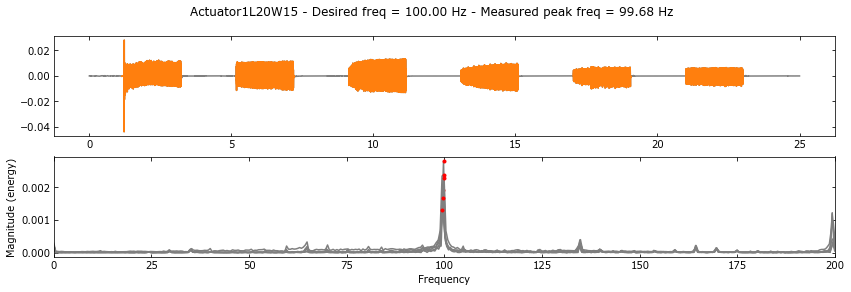

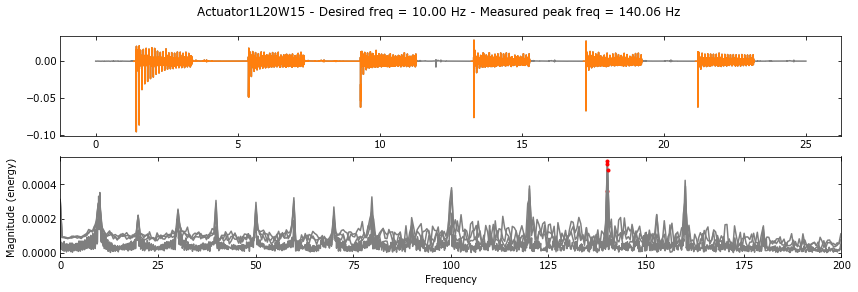

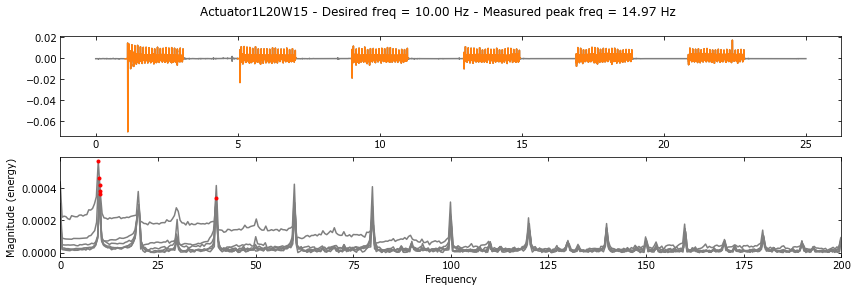

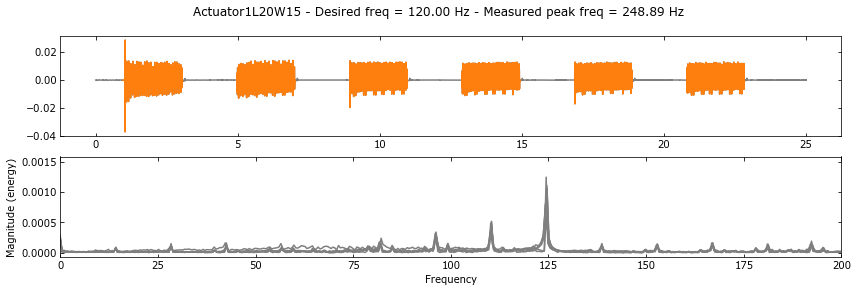

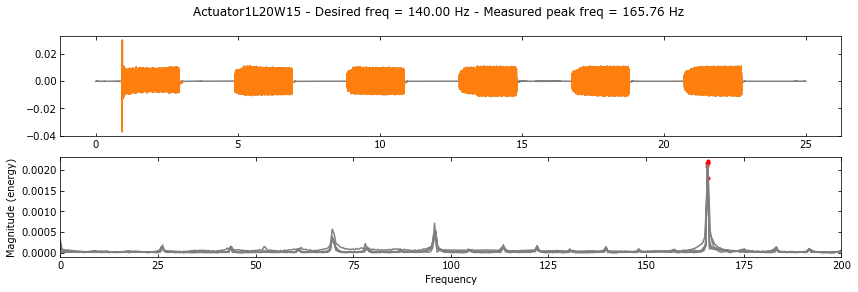

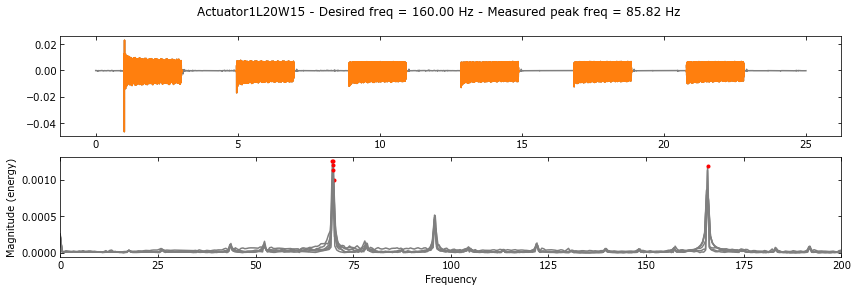

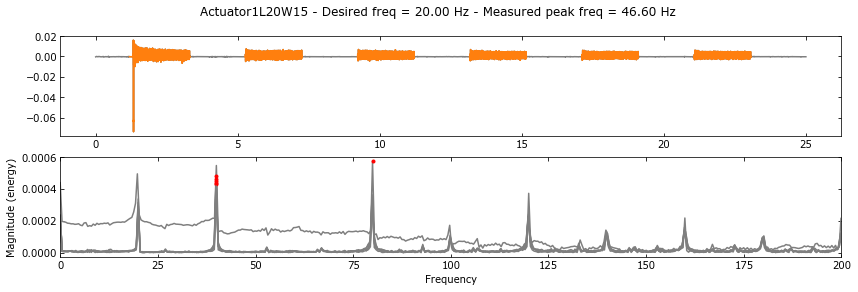

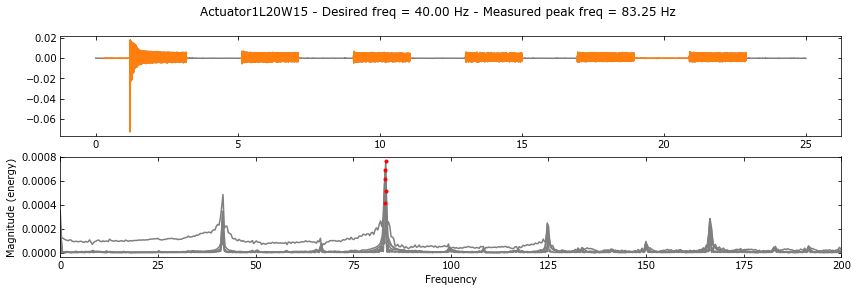

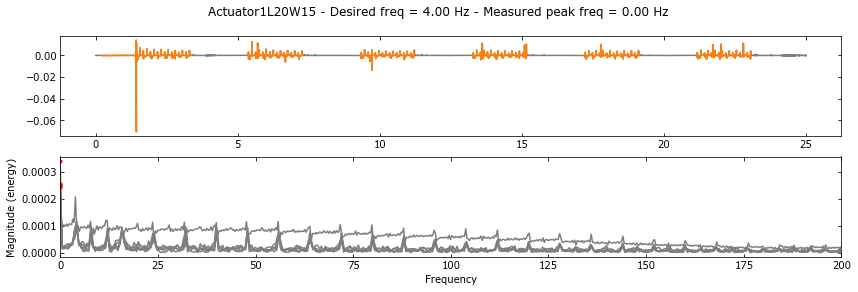

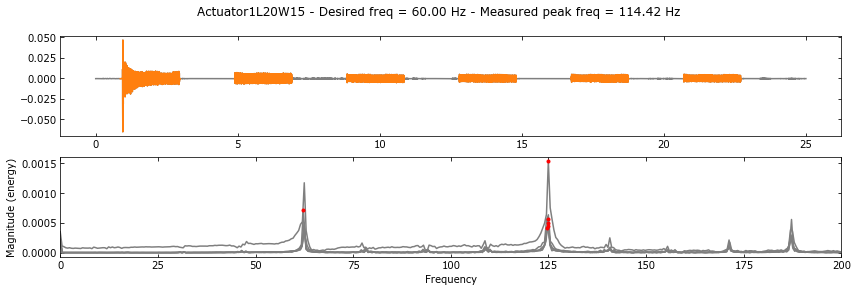

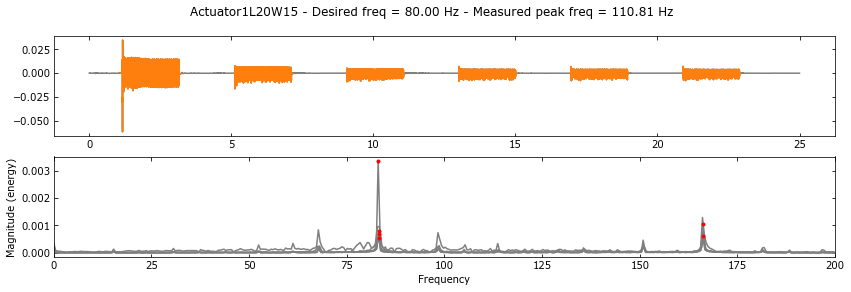

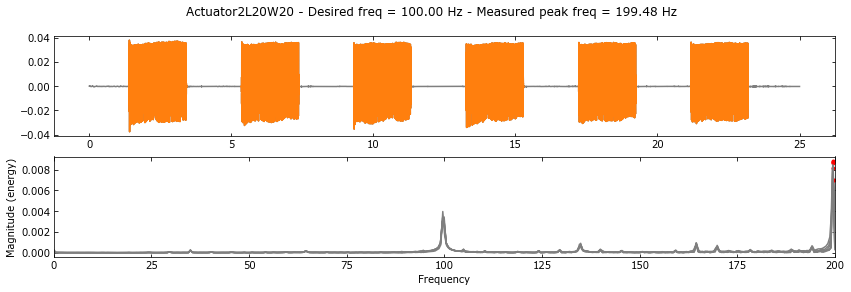

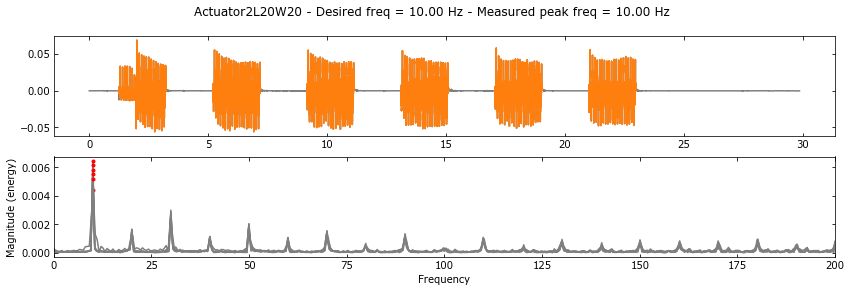

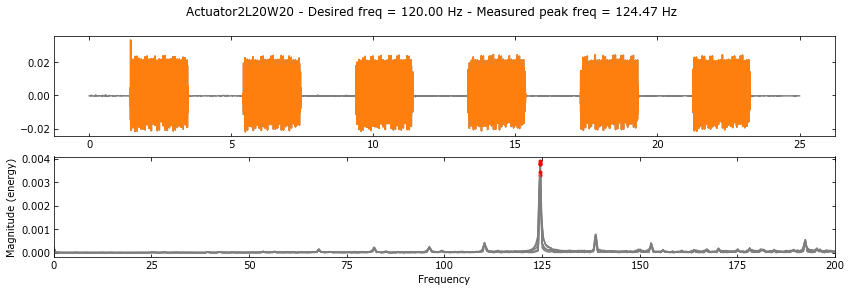

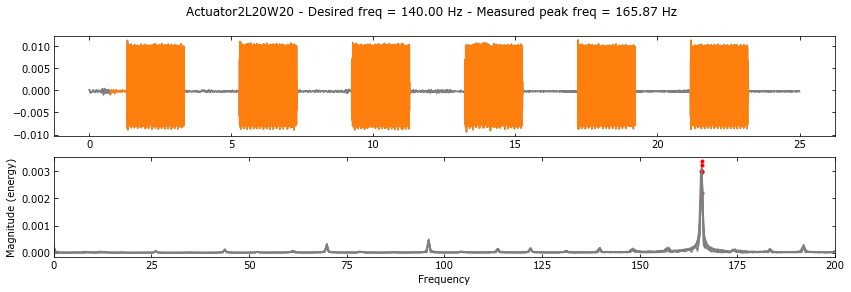

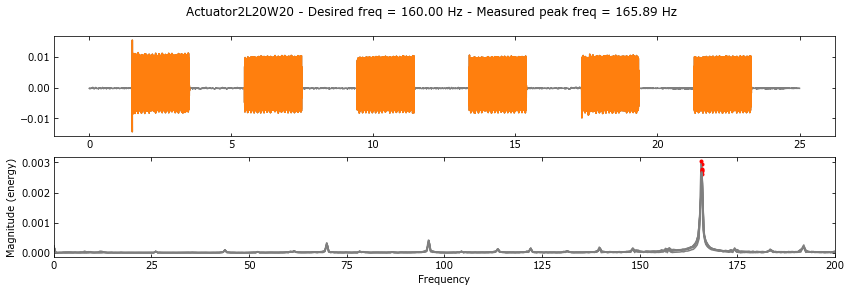

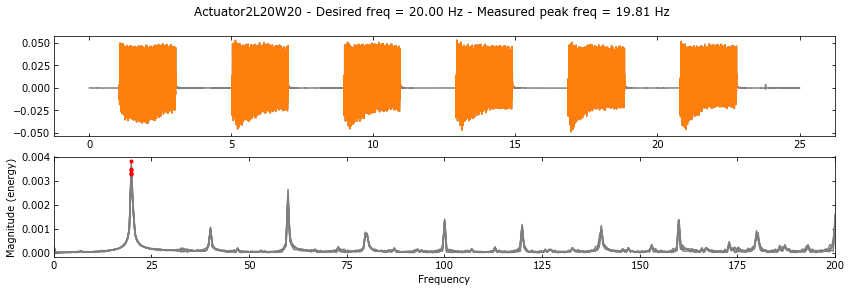

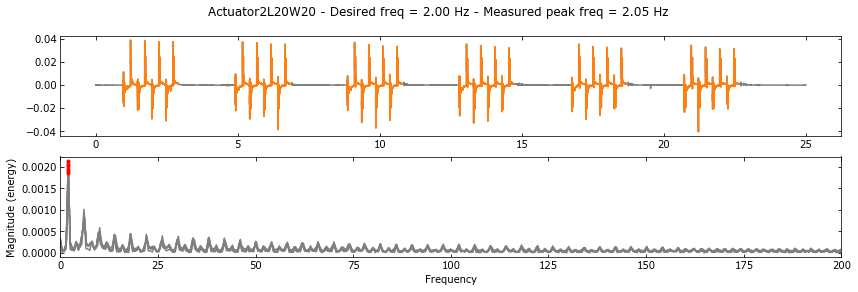

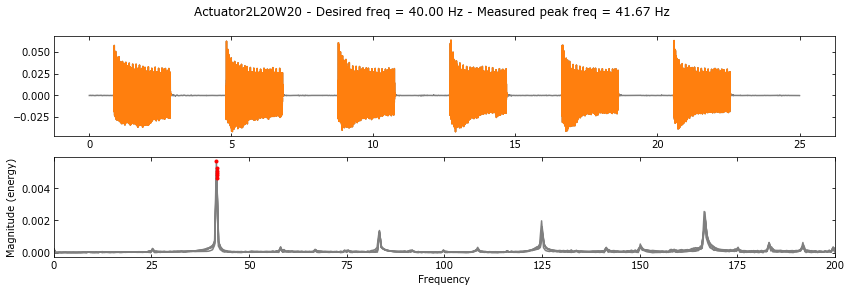

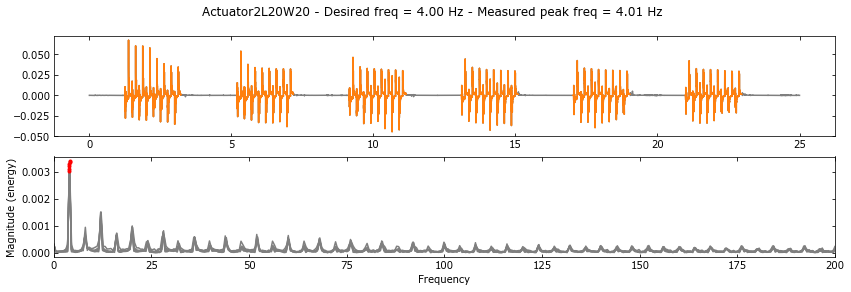

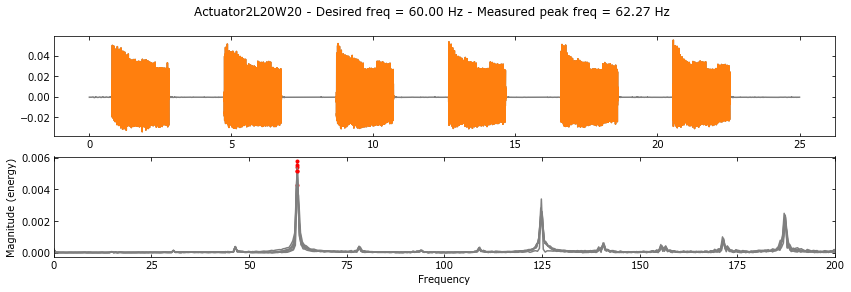

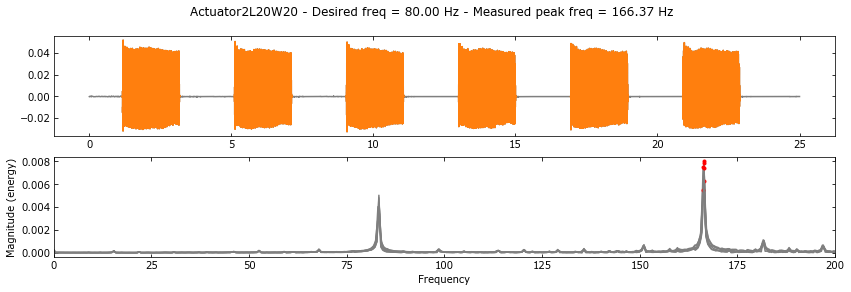

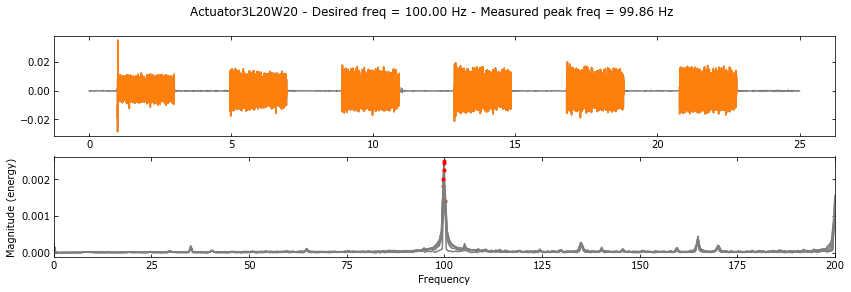

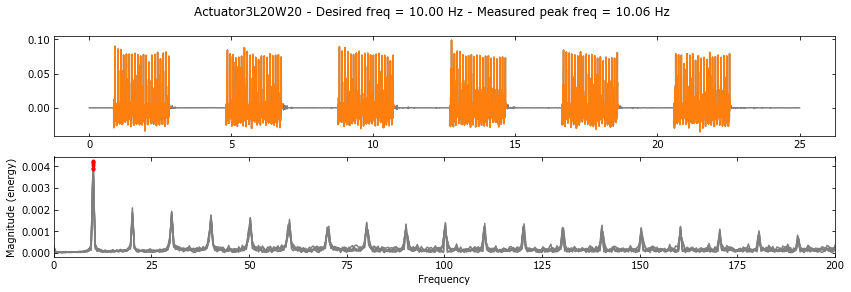

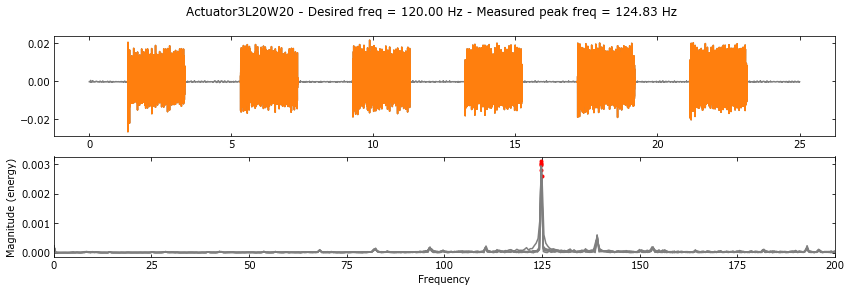

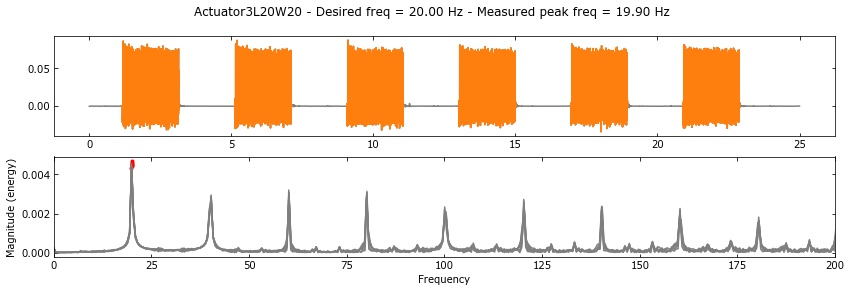

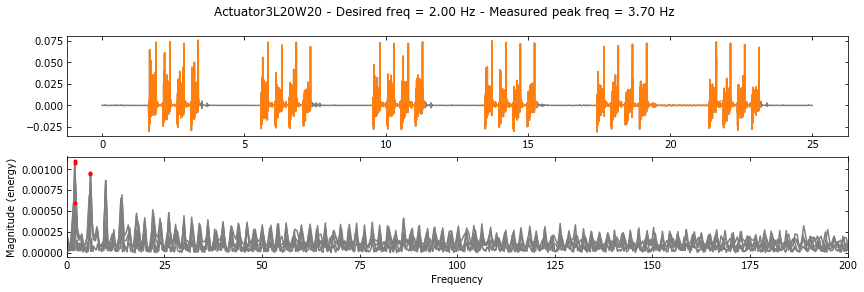

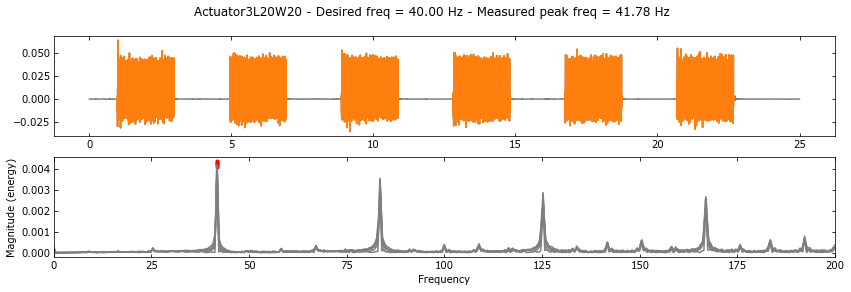

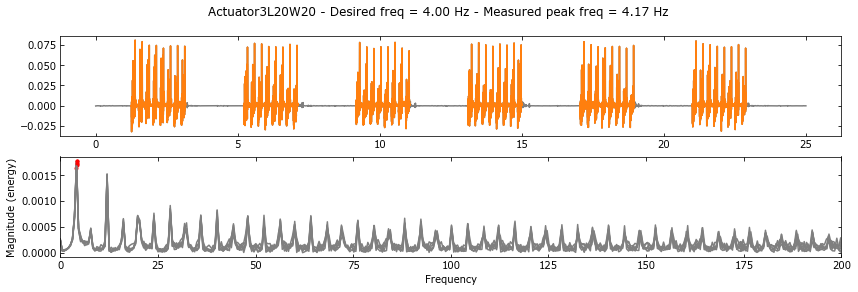

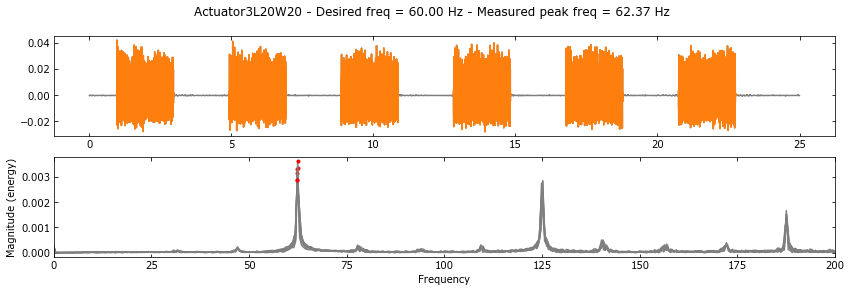

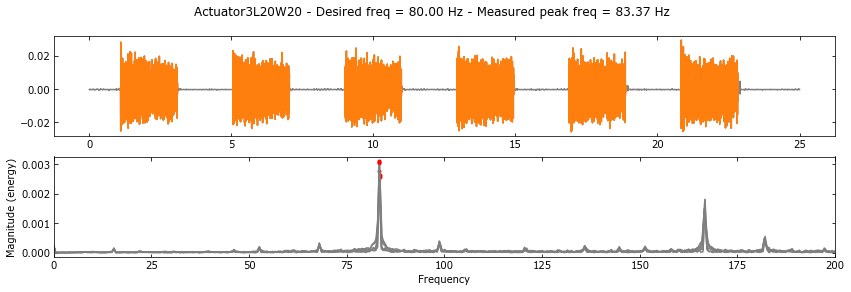

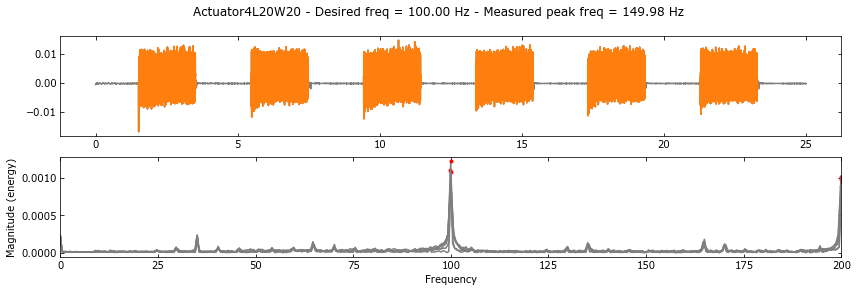

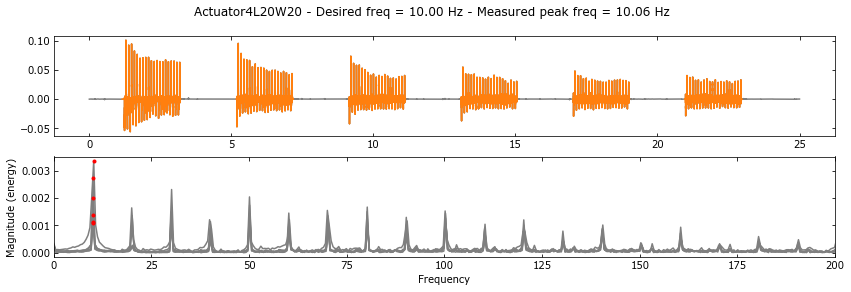

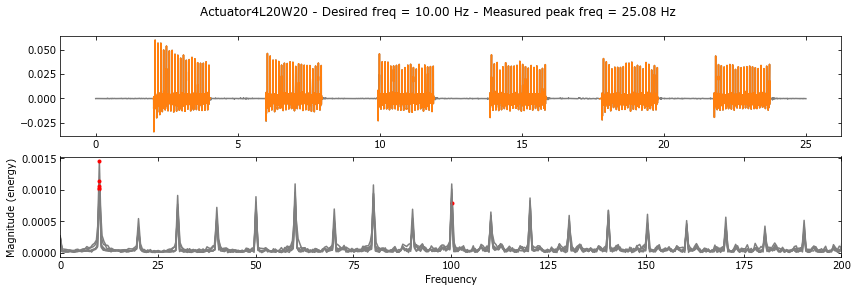

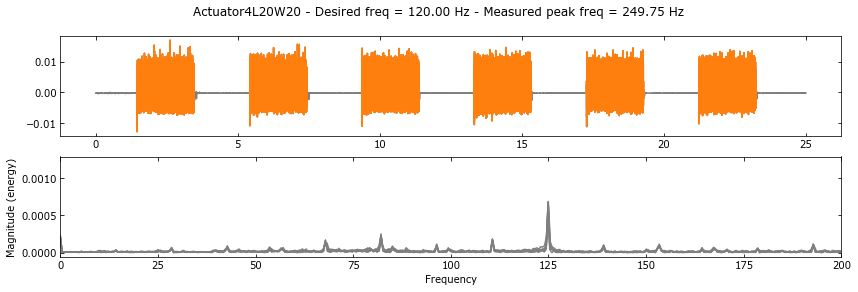

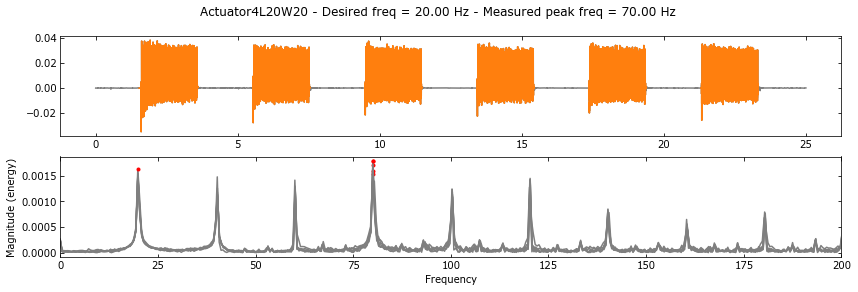

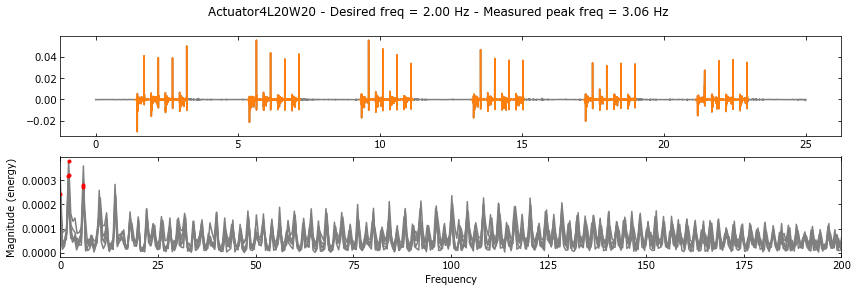

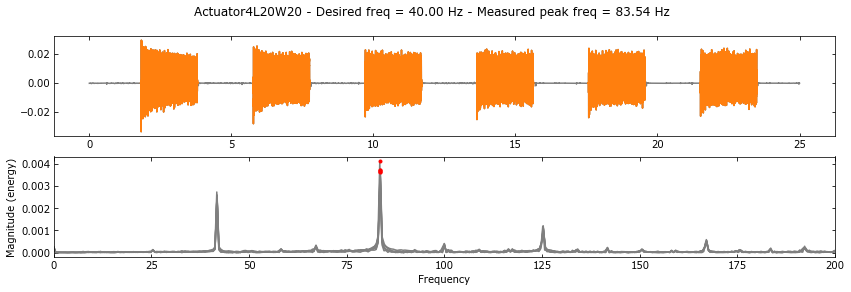

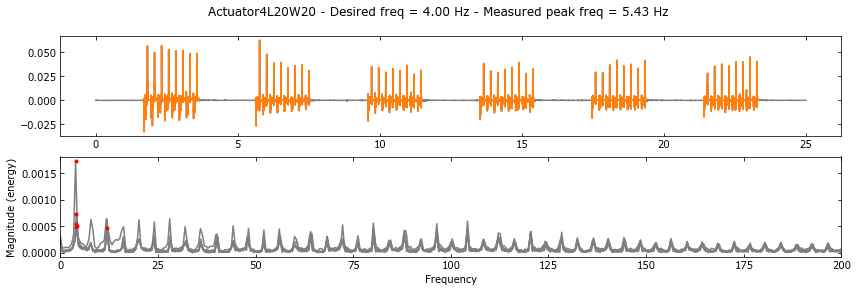

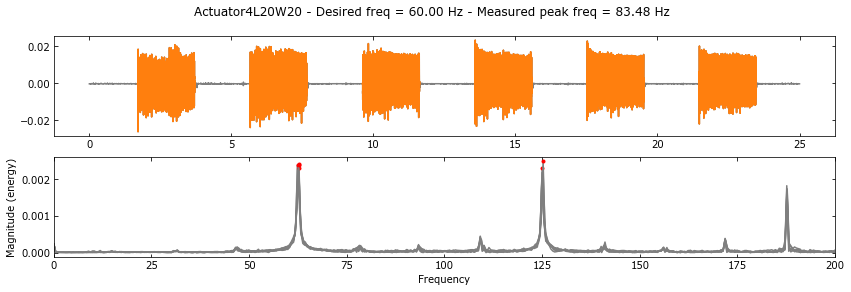

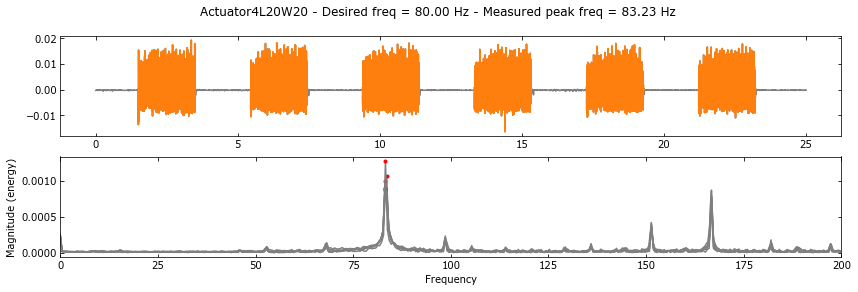

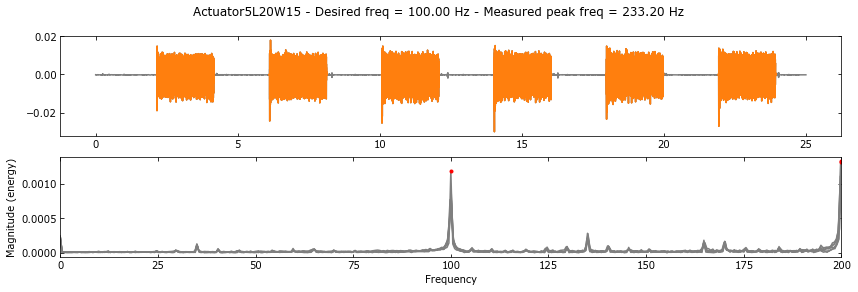

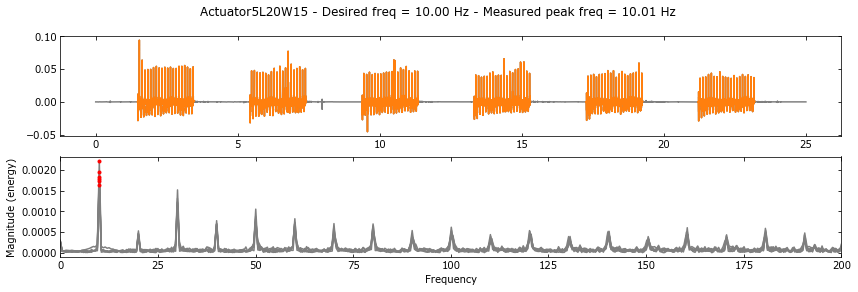

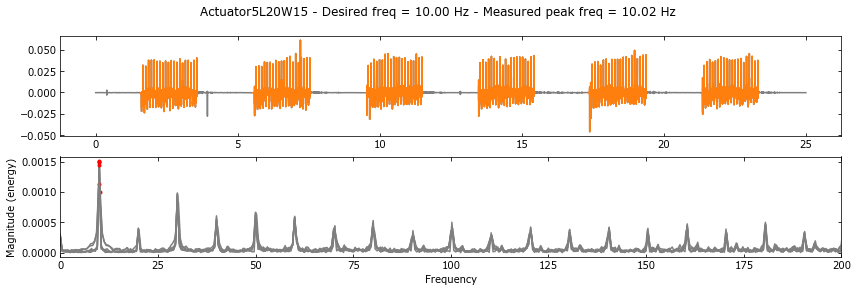

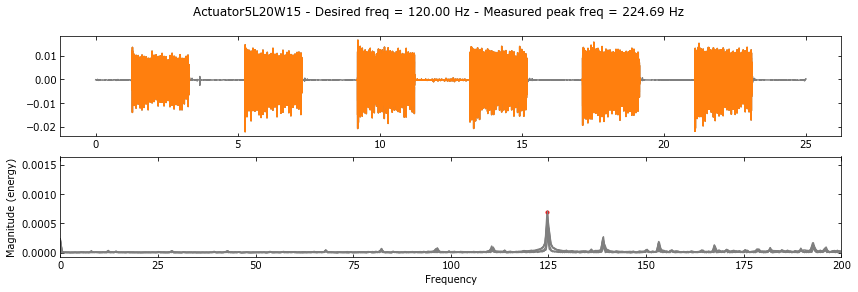

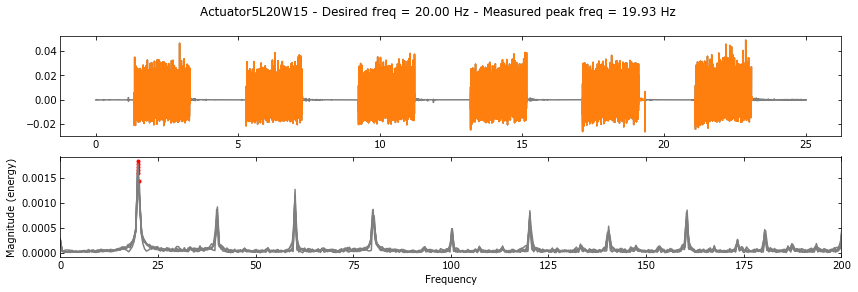

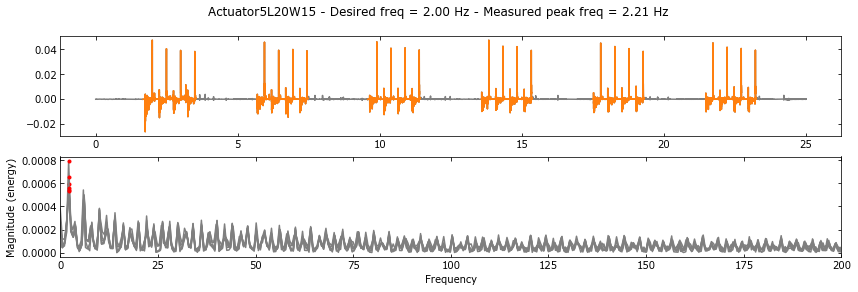

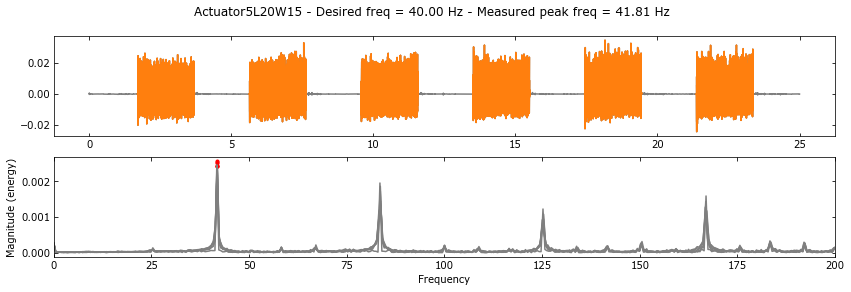

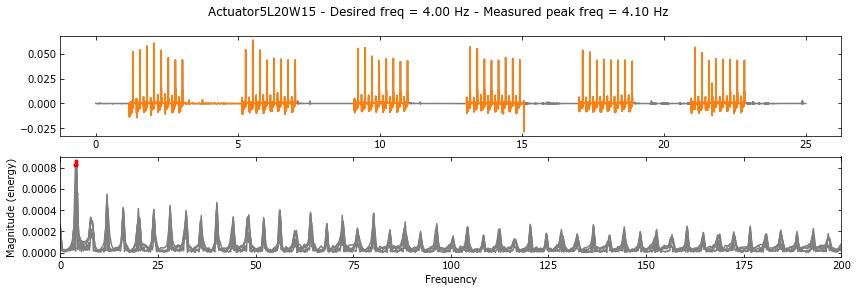

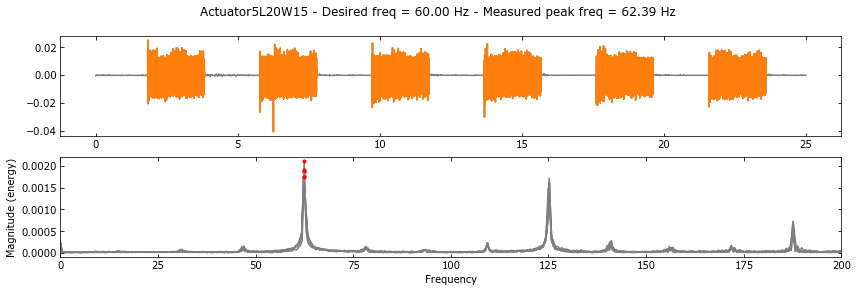

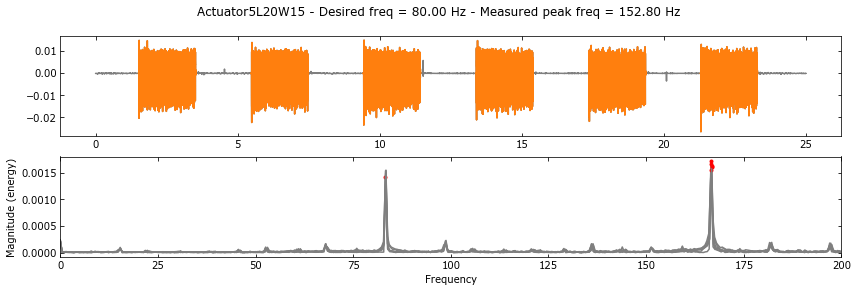

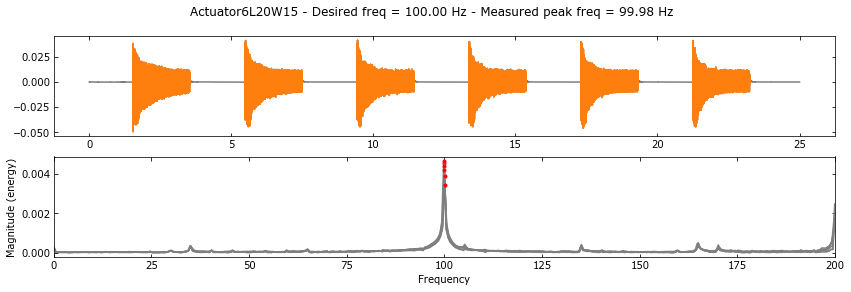

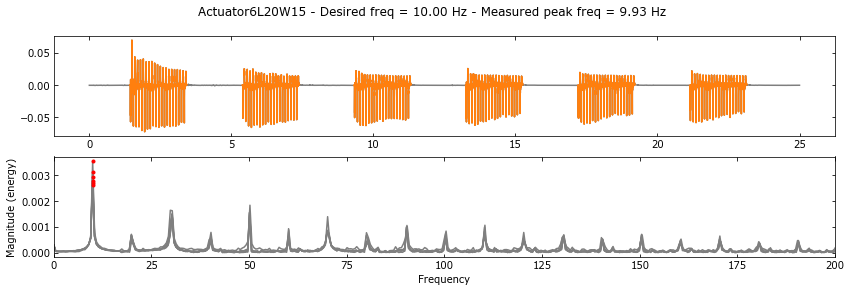

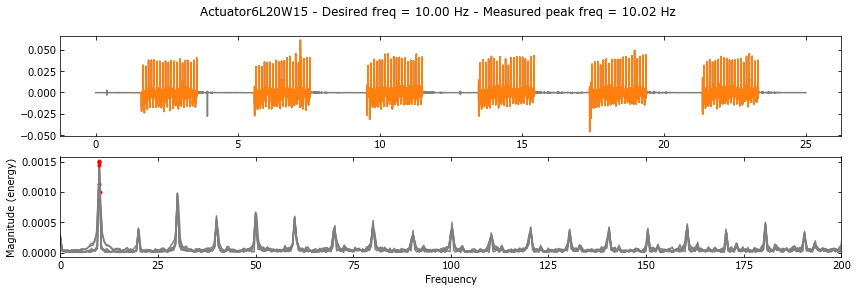

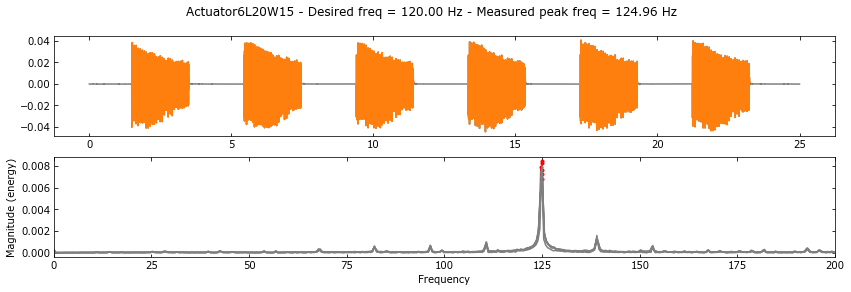

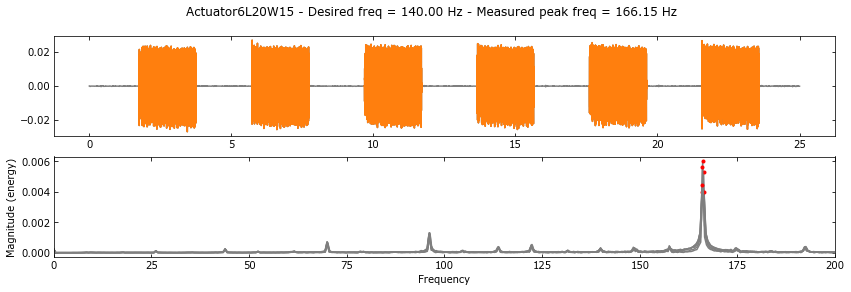

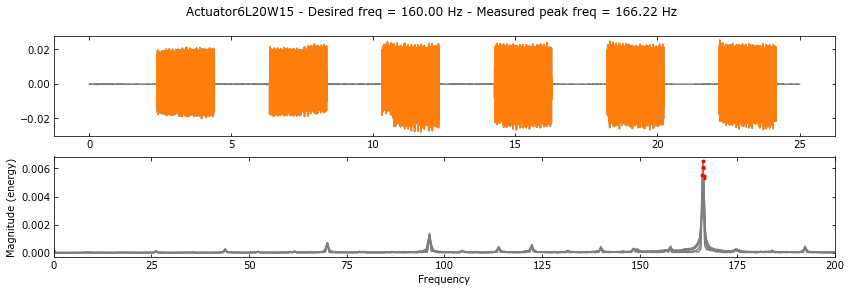

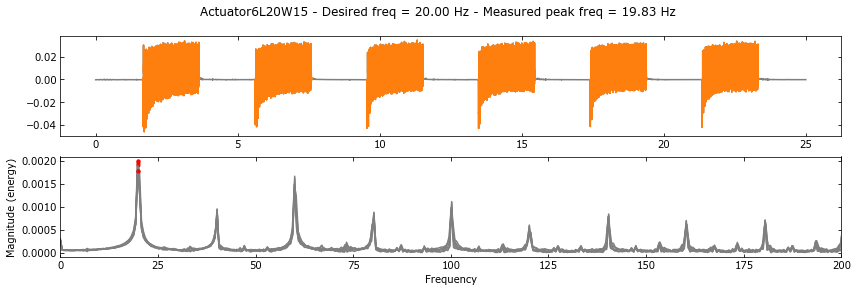

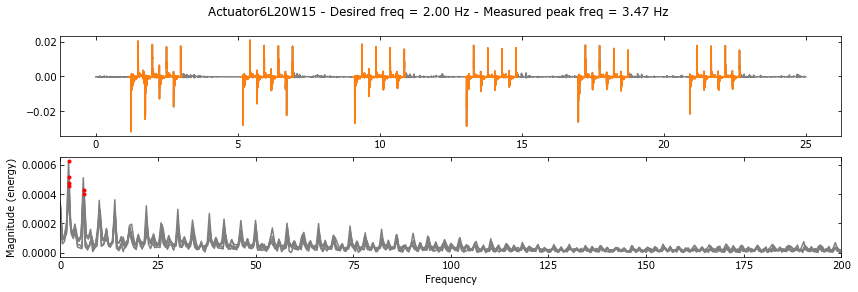

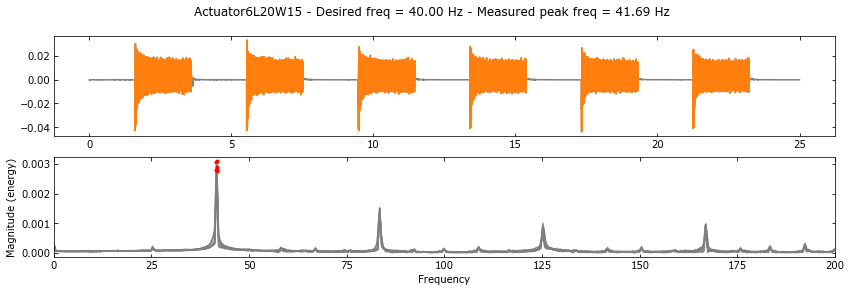

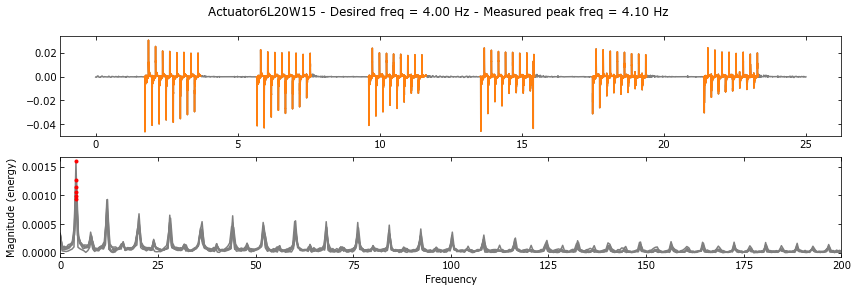

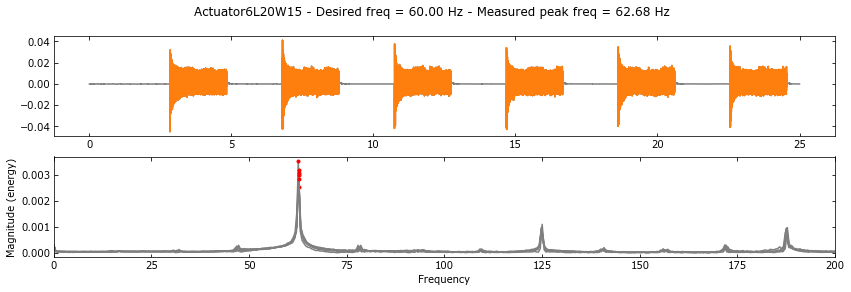

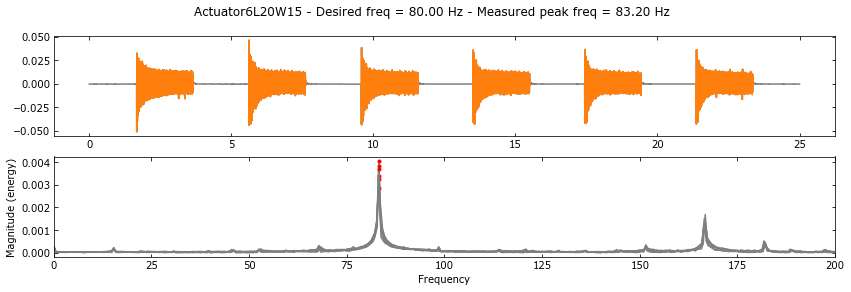

In [2]:
'''
Analysis of Laser Vibrometer Measurement (Added on 2023.01.19)
'''
# DataPath = './SoftActuator202301'
DataPath = './FreqResponseData20230127'

# VibroGo data format
VibroGoHeadRowIndex = 3
TimeLabel = '[ s ]'
VibVelocityLabel = '[ m/s ]'

# Settings for data segmentation
# segmentLen = segmentTime + segmentInterval # (secs) 
# selectedStartT = 0.5 # (secs) Selected the start time of the window for analysis
# selectedLen = 2 # (secs) Selected the length of the window for analysis

''' Data preprocess and segmentation '''
FSdata = []

for root, directories, files in walk(DataPath):
    for fileName in files:
        
        actuatorName = decodeData(root, '\w+', frontCode='Actuator', rearCode='', isString=True)
        
        actuatorLength = decodeData(fileName, '[\d+\.]*\d+', frontCode='L', rearCode='')
        
        actuatorWidth = decodeData(fileName, '[\d+\.]*\d+', frontCode='W', rearCode='')
        
        infillVolume = decodeData(fileName, '[\d+\.]*\d+', frontCode='', rearCode='mL')
        
        actuateFreq = decodeData(fileName, '[\d+\.]*\d+', rearCode='Hz') 
        
        actuateVoltageLevel= decodeData(fileName, '\d+', frontCode='V') 
        
        trialNum = decodeData(fileName, '\d+', frontCode='trial') 
        if(trialNum is None):
            trialNum = 0;
        
        print("%s, L%f, W%f, infill%f, freq%f, V%d, trial%d" % (actuatorName, actuatorLength, actuatorWidth,
                                                                infillVolume, actuateFreq, actuateVoltageLevel, trialNum))
        
        metaData = pd.read_csv(ospa.join(root, fileName), header=None, nrows=VibroGoHeadRowIndex, sep='\t')
        display(HTML(metaData.to_html(index=False, header=None)))
        readData = pd.read_csv(ospa.join(root, fileName), header = VibroGoHeadRowIndex, sep='\t')
        
        t = readData[TimeLabel].to_numpy(dtype='float64')
        vibVelocity = readData[VibVelocityLabel].to_numpy(dtype='float64')
        
        Fs = 1/np.mean(np.diff(t))

        fig,ax = plt.subplots(2,1,dpi=72, figsize=(14,4))
        ax[0].plot(t, vibVelocity, color='tab:grey')
        
        
        ''' Data Segmentation '''
        segIndPair = onsetSegmentation(vibVelocity, 7000, cutFreqRatio=0.004)
        
        rmsEnergy = []
        freqMagValue = []
        measuredPeakFreq = []
        for i0,i1 in segIndPair:
            ax[0].plot(t[i0:i1], vibVelocity[i0:i1], '-', color='tab:orange')
            
            rmsEnergy.append(np.sqrt(np.mean(np.square(vibVelocity[i0:i1])))) # Compute RMS energy
            
            spectr, f, _ = ax[1].magnitude_spectrum(vibVelocity[i0:i1], Fs=Fs, color='tab:grey', window=mlab.window_none)
            
            idx = spectr.argmax()           
            freqMagValue.append(spectr[idx]) # Compute the spectral magnitude of desired frequency
            measuredPeakFreq.append(f[idx])
            ax[1].plot(f[idx], spectr[idx], '.r') 
            
        ax[1].set_xlim([0, 200]) # (Hz) Zoom spectrum plot at selected frequency range
        
        fig.suptitle("%s - Desired freq = %.2f Hz - Measured peak freq = %.2f Hz" % 
                     (actuatorName, actuateFreq, np.mean(measuredPeakFreq)))


        FSdata.append([actuatorName, actuatorLength, actuatorWidth, infillVolume, actuateFreq, actuateVoltageLevel, trialNum,
                       np.mean(measuredPeakFreq), np.array(rmsEnergy), np.array(freqMagValue)])
        
print("Sampling frequency = %.2fHz" % Fs)    
        
FSdata = pd.DataFrame(FSdata, columns = ['ActuatorName','ActuatorLength','ActuatorWidth','InfillVolume','ActuateFreq',
                                         'ActuateVoltageLevel','TrialNum','MeasuredPeakFreq','RMSEnergy','PeakFreqMag'])
display(FSdata)

Text(0, 0.5, 'Amplitude (m/s)')

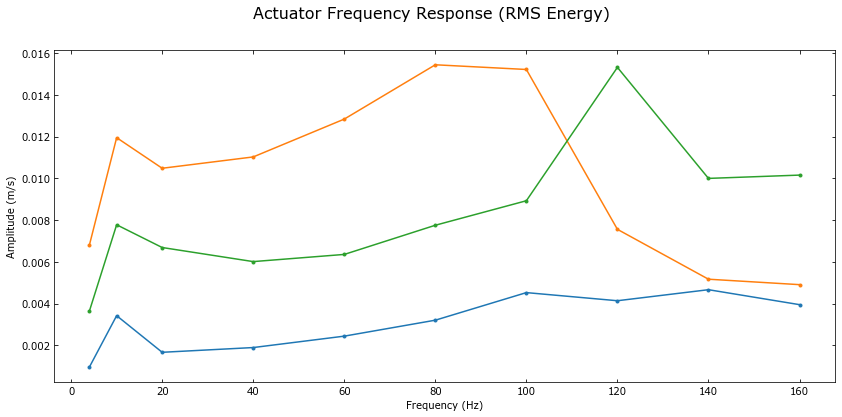

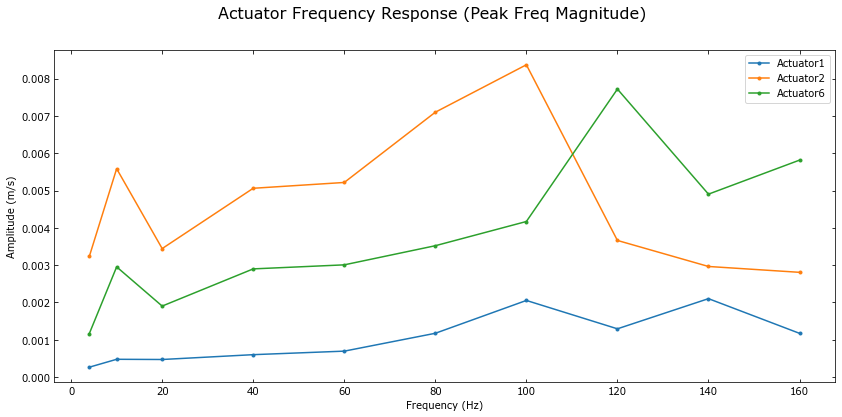

In [20]:
''' Visulize Frequency Response'''
def dataMean(df, selectFreq):
    freqNum = len(selectFreq)
    
    rmsEnergyMean = []
    peakFreqMagMean = []
    for i in range(freqNum):
        ind = (df['ActuateFreq'] == selectFreq[i])

        if len(ind) > 0:
            rmsEnergyMean.append(np.mean(np.asarray(df.loc[ind, 'RMSEnergy'].values[0], dtype='float64')))
            peakFreqMagMean.append(np.mean(np.asarray(df.loc[ind, 'PeakFreqMag'].values[0], dtype='float64')))
        else:
            rmsEnergyMean.append(None)
            peakFreqMagMean.append(None)
    return rmsEnergyMean, peakFreqMagMean

selectFreq = [4, 10, 20, 40, 60, 80, 100, 120, 140, 160]


''' Compare spectrum '''
ax0,fig0 = aPlot(figName='Actuator Frequency Response (RMS Energy)')
# fig0.set_figuresize((14,3))
ax1,fig1 = aPlot(figName='Actuator Frequency Response (Peak Freq Magnitude)')

rmsEnergyMean, peakFreqMagMean = dataMean(FSdata.loc[FSdata['ActuatorName'] == 'Actuator1L20W15'], selectFreq)
ax0.plot(selectFreq, rmsEnergyMean, '.-', label='Actuator1')
ax1.plot(selectFreq, peakFreqMagMean, '.-', label='Actuator1')
plt.legend(['Actuator1','Actuator2'])

rmsEnergyMean, peakFreqMagMean = dataMean(FSdata.loc[FSdata['ActuatorName'] == 'Actuator2L20W20'], selectFreq)
ax0.plot(selectFreq, rmsEnergyMean, '.-', label='Actuator2')
ax1.plot(selectFreq, peakFreqMagMean, '.-', label='Actuator2')

# rmsEnergyMean, peakFreqMagMean = dataMean(FSdata.loc[FSdata['ActuatorName'] == 'Actuator3L20W20'], selectFreq)
# ax0.plot(selectFreq, rmsEnergyMean, '.-', label='Actuator3')
# ax1.plot(selectFreq, peakFreqMagMean, '.-', label='Actuator3')

# rmsEnergyMean, peakFreqMagMean = dataMean(FSdata.loc[FSdata['ActuatorName'] == 'Actuator4L20W20'], selectFreq)
# ax0.plot(selectFreq, rmsEnergyMean, '.-', label='Actuator4')
# ax1.plot(selectFreq, peakFreqMagMean, '.-', label='Actuator4')

# rmsEnergyMean, peakFreqMagMean = dataMean(FSdata.loc[FSdata['ActuatorName'] == 'Actuator5L20W15'], selectFreq)
# ax0.plot(selectFreq, rmsEnergyMean, '.-', label='Actuator5')
# ax1.plot(selectFreq, peakFreqMagMean, '.-', label='Actuator5')

rmsEnergyMean, peakFreqMagMean = dataMean(FSdata.loc[FSdata['ActuatorName'] == 'Actuator6L20W15'], selectFreq)
ax0.plot(selectFreq, rmsEnergyMean, '.-', label='Actuator6')
ax1.plot(selectFreq, peakFreqMagMean, '.-', label='Actuator6')

plt.legend();

ax0.set_xlabel('Frequency (Hz)')
ax0.set_ylabel('Amplitude (m/s)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (m/s)')

# ax.set_ylim([-40, 0]);